# Further data analysis

The outline of this notebook:

1. Import data
2. Explore artist data using the dataframes:
    * artists
    * atu_relationship
    * similar_artist
    * user_artist_w
3. Explore user data using the dataframes:
    * Pass
    * Pass

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 16)

from datetime import datetime
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split

In [116]:
def plot_subjects(df,colName, title, xlabel, ylabel):   
    fontdict = {"fontsize":20}
    plt.barh(df.index, df[colName].values,)
    plt.title(title,fontdict)
    plt.ylabel(ylabel,fontdict)
    plt.xlabel(xlabel,fontdict)
    plt.show()

In [3]:
artist = pd.read_csv("data/processed_data/artist.csv")

In [4]:
atu = pd.read_csv("data/processed_data/atu_relationship.csv")

In [5]:
similar_artist = pd.read_csv("data/processed_data/similar_artist.csv")

In [6]:
user_artist_w = pd.read_csv("data/user_artists.dat", sep="\t")

In  the user_artist_w df, the weight refers to how much the user has listened to an artist.  
In the code below i find the top ten most listened to artists and present them in a barplot.

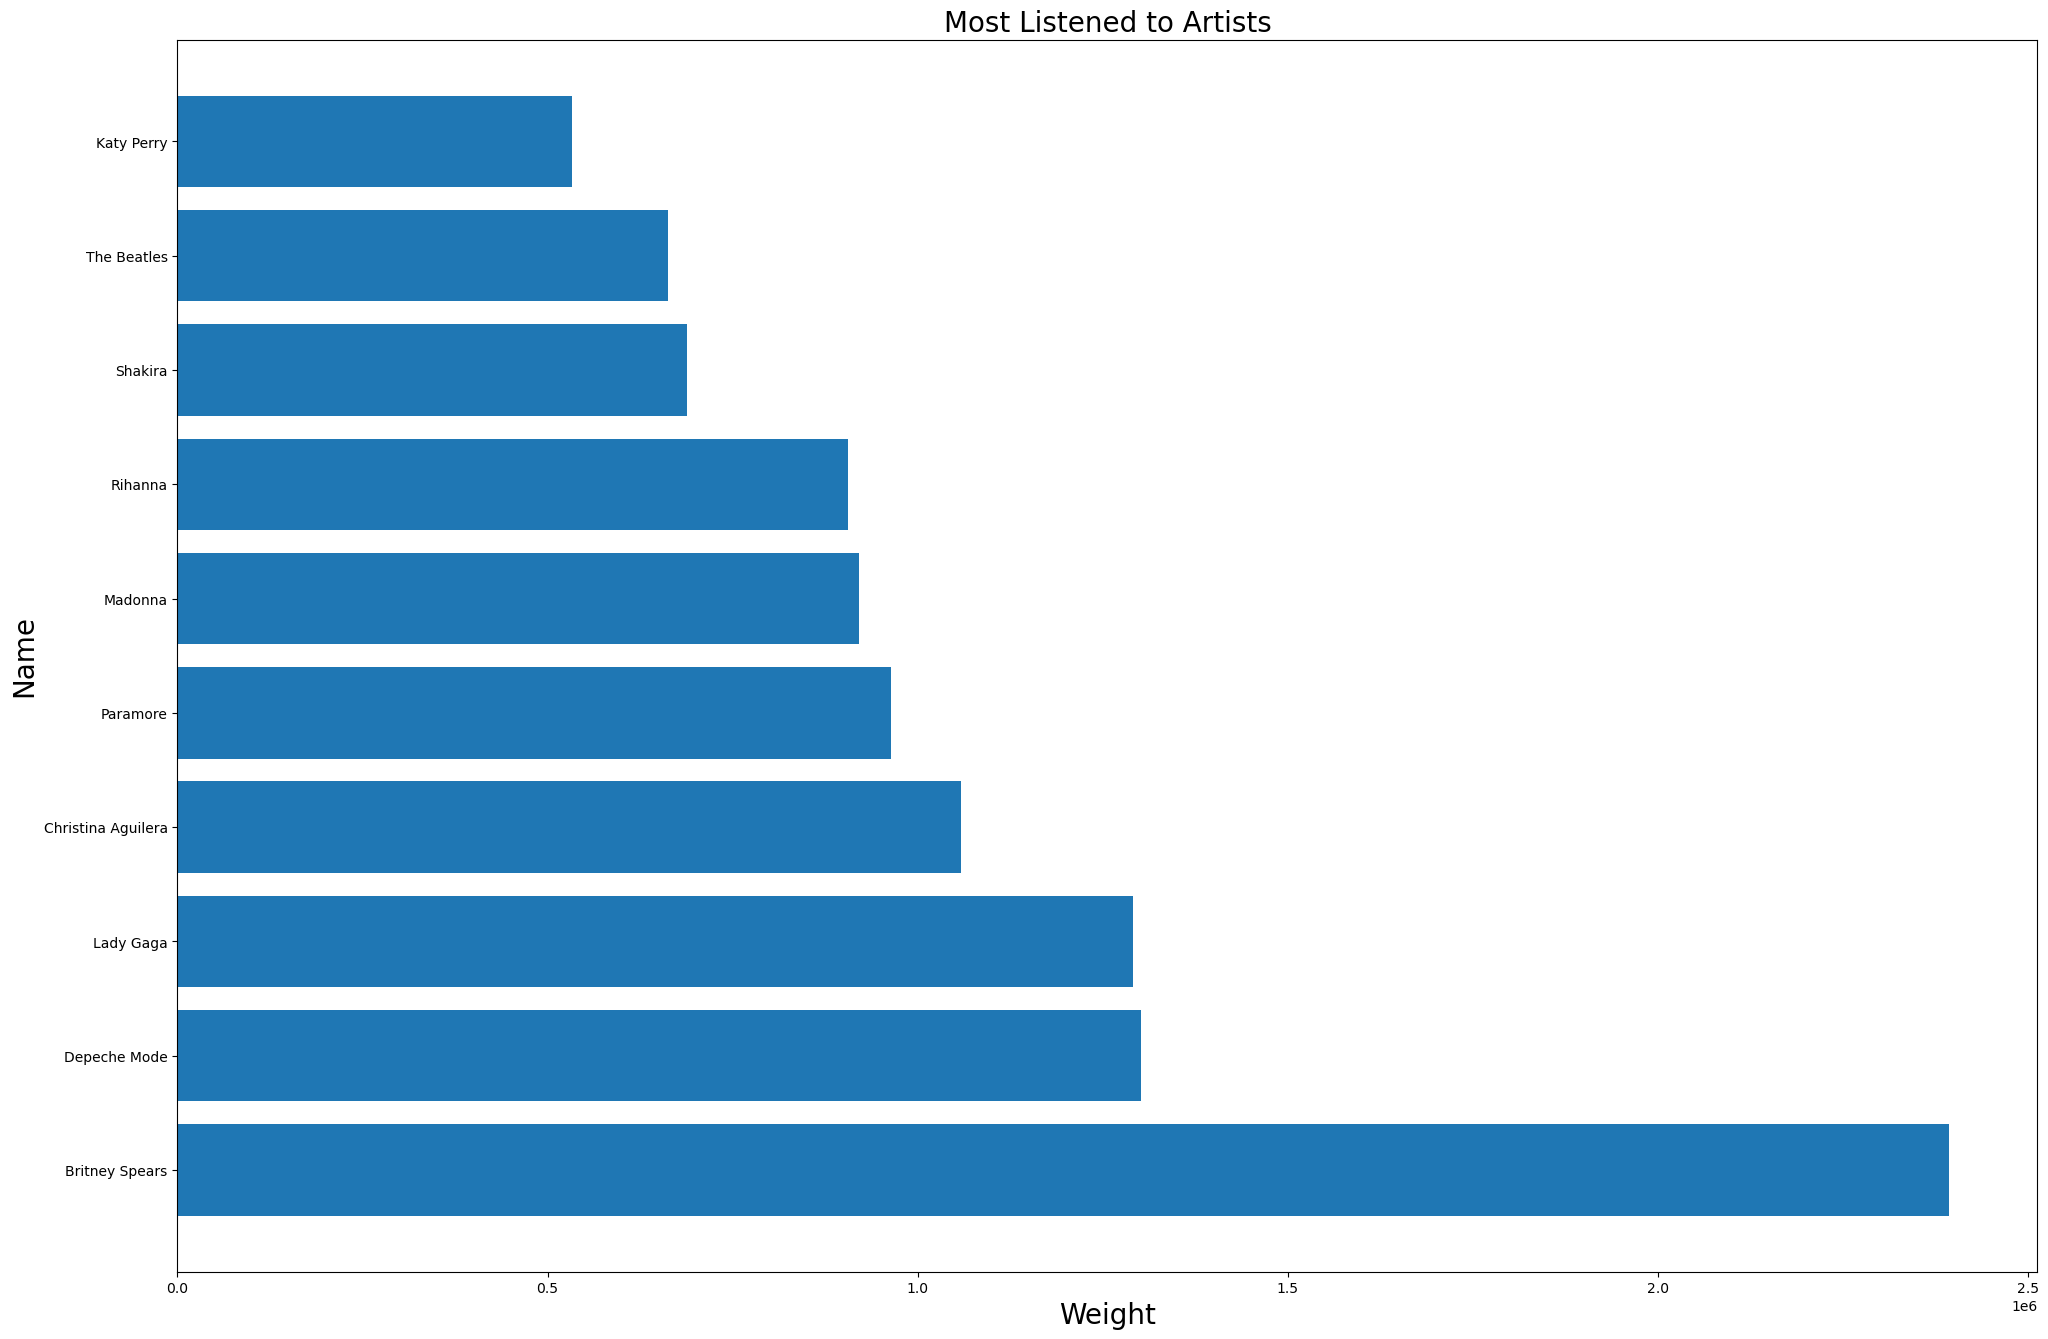

In [7]:
top_listened_artists = user_artist_w.groupby(
"artistID"
).sum(
)["weight"].sort_values(
ascending=False).head(10)

top_listened_artists_df = artist.set_index(
    "artistID").loc[top_listened_artists.index].set_index("name")

top_listened_artists_df["total_weight"] = top_listened_artists.values
plot_subjects(top_listened_artists_df,"total_weight", "Most Listened to Artists", "Weight", "Name")

In [8]:
user_friend = pd.read_csv("data/user_friends.dat", sep="\t")

In [9]:
user_artist_w["userID"].value_counts()

2       50
1376    50
1388    50
1387    50
1386    50
        ..
2085     1
1758     1
615      1
1013     1
1731     1
Name: userID, Length: 1892, dtype: int64

In [10]:
user_artist_w["userID"].value_counts()[user_artist_w["userID"].value_counts() > 9]

2       50
1376    50
1388    50
1387    50
1386    50
        ..
701     11
797     11
745     10
869     10
1773    10
Name: userID, Length: 1874, dtype: int64

In [11]:
user_friend

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


### Checking the scraped artist tags.

In [29]:
u_tags = pd.read_csv("data/top_five_artists_tags_2.csv")

In [16]:
artist = pd.read_csv("data/artists.dat", sep="\t")

In [30]:
missed_artist = artist.set_index("id").loc[list(set(artist["id"]) - set(u_tags["artistID"]))].reset_index()

In [83]:
missed_artist

,id,name,url,pictureURL
0,2080,NX Zero,http://www.last.fm/music/NX+Zero,http://userserve-ak.last.fm/serve/252/54957459...
1,1794,Inspiral Carpets,http://www.last.fm/music/Inspiral+Carpets,http://userserve-ak.last.fm/serve/252/82262.jpg
2,2371,Day Eleven,http://www.last.fm/music/Day+Eleven,http://userserve-ak.last.fm/serve/252/23238061...
3,563,Small Faces,http://www.last.fm/music/Small+Faces,http://userserve-ak.last.fm/serve/252/24083505...
4,3190,Suicidal Romance,http://www.last.fm/music/Suicidal+Romance,http://userserve-ak.last.fm/serve/252/13182087...
5,2648,The Beat,http://www.last.fm/music/The+Beat,http://userserve-ak.last.fm/serve/252/70355.jpg
6,1273,Vinterland,http://www.last.fm/music/Vinterland,http://userserve-ak.last.fm/serve/252/21130245...
7,2618,Before Their Eyes,http://www.last.fm/music/Before+Their+Eyes,http://userserve-ak.last.fm/serve/252/40977655...
8,1628,Das EFX,http://www.last.fm/music/Das+EFX,http://userserve-ak.last.fm/serve/252/36863573...


Scaper somehow missed 9 artists, I will quickly fix this.

In [73]:
import requests
from bs4 import BeautifulSoup
def get_missing_tags(missed_artist):
    extra_artist_data = {"artistID":[],"tag1":[],  "tag2":[],  "tag3":[],  "tag4":[],  "tag5":[]}
    artistID_list, url_list = missed_artist["id"], missed_artist["url"]
    for current_url, current_artistID in zip(url_list,artistID_list):
        try:
            response = requests.get(current_url)
            soup = BeautifulSoup(response.text, 'html.parser')
            extra_artist_data["artistID"].append(current_artistID)
            
            for i, tag in enumerate(soup.find_all("li", "tag")[:5]):
                 extra_artist_data[f"tag{i+1}"].append(tag.text)
        except:
            pass
    return extra_artist_data          

In [75]:
missing_tags = get_missing_tags(missed_artist)
missing_tags = pd.DataFrame(missing_tags)

In [78]:
missing_tags

,artistID,tag1,tag2,tag3,tag4,tag5
0,2080,rock,brazilian,emocore,hardcore,emo
1,1794,madchester,britpop,indie,manchester,90s
2,2371,finnish,alternative rock,rock,alternative,amazing
3,563,60s,mod,classic rock,psychedelic,rock
4,3190,darkwave,ebm,dark electro,gothic,electrogoth
5,2648,ska,two-tone,new wave,british,80s
6,1273,black metal,melodic black metal,swedish black metal,swedish,symphonic black metal
7,2618,post-hardcore,emocore,screamo,christian,post hardcore
8,1628,hip-hop,rap,old school,hip hop,east coast


In [87]:
# Saving the fixed dataset.
u_tags.append(missing_tags).reset_index(drop=True).sort_values(by="artistID").to_csv("data/processed_data/top_tags.csv", index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_8892\557092625.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  u_tags.append(missing_tags).reset_index(drop=True).sort_values(by="artistID").to_csv("data/processed_data/top_tags.csv", index=False)


### Looking into all the tags found.

In [89]:
top_tags = pd.read_csv("data/processed_data/top_tags.csv")

In [90]:
top_tags.head()

,artistID,tag1,tag2,tag3,tag4,tag5
0,1,visual kei,j-rock,japanese,gothic,gothic rock
1,2,darkwave,gothic,electronic,industrial,german artist
2,3,black metal,norwegian black metal,norwegian,true norwegian black metal,norwegian artist
3,4,visual kei,j-rock,gothic,gothic metal,japanese
4,5,gothic rock,darkwave,gothic,deathrock,industrial


In [128]:
top_tag_count = pd.DataFrame(
    pd.DataFrame(
    top_tags.drop(columns="artistID"
    ).values.flatten()).value_counts(
    ).head(20)).rename(columns={0:"Count"}
    )
top_tag_count.index = top_tag_count.index.get_level_values(0) 

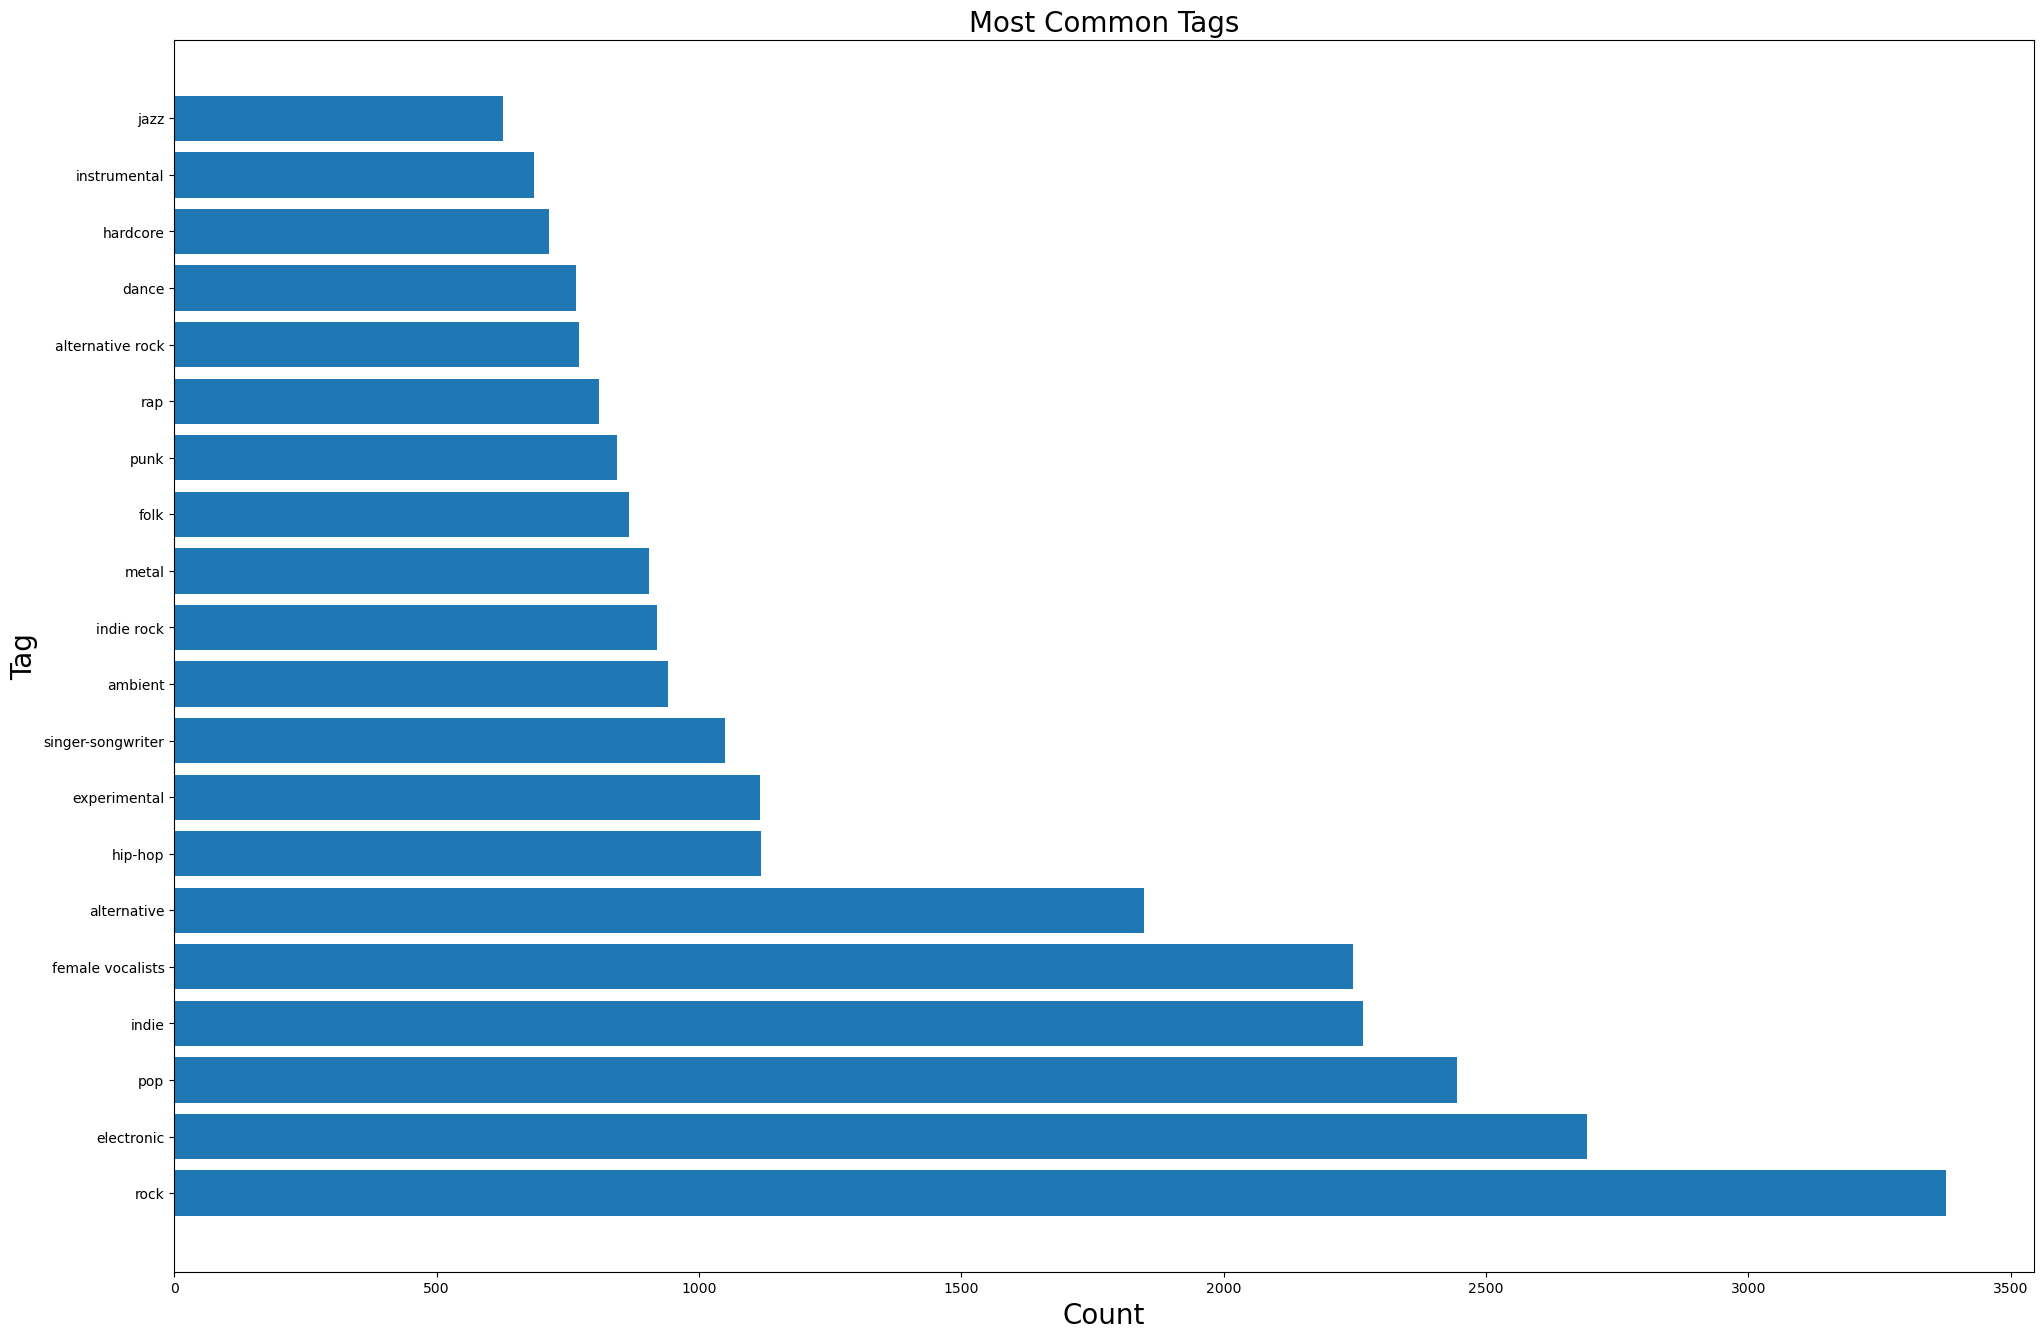

In [129]:
plot_subjects(top_tag_count,"Count", "Most Common Tags", "Count", "Tag")

I plan on using the tags to help create a content based recommender system.  
I will first need to embed the tags.

I will start off by joining the five tags into one string.  
I will then use ... model to transfor the text into a vector representation.

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

C:\Users\PC\anaconda3\envs\recomSys\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [172]:
artist

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda Galás,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [171]:
top_tags

,artistID,tag1,tag2,tag3,tag4,tag5
0,1,visual kei,j-rock,japanese,gothic,gothic rock
1,2,darkwave,gothic,electronic,industrial,german artist
2,3,black metal,norwegian black metal,norwegian,true norwegian black metal,norwegian artist
3,4,visual kei,j-rock,gothic,gothic metal,japanese
4,5,gothic rock,darkwave,gothic,deathrock,industrial
...,...,...,...,...,...,...
17627,18741,avant-garde,experimental,female vocalists,singer-songwriter,avantgarde
17628,18742,new wave,post-punk,polish,rock,80s
17629,18743,industrial,industrial metal,industrial rock,aggro industrial,coldwave
17630,18744,trip-hop,oz alchemist,blue sky black death,illogic,free the robots


In [159]:
top_tags_text = top_tags.drop(columns=["artistID"])
top_tags_text["tags"] = top_tags_text.fillna(" ").T.apply(lambda row: ", ".join(row))
top_tags_text = top_tags_text[["tags"]]

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(top_tags_text["tags"], show_progress_bar=True)

In [212]:
top_tags[["artistID", "tag1"]].groupby("tag1").mean()

,artistID
tag1,
11,14924.166667
13,16250.000000
14,2329.000000
2 of 10 stars,9181.000000
20th century,16420.000000
...,...
yeah!,7830.000000
youtube,4465.500000
yuri,2396.000000


In [213]:
embeddings_df = pd.DataFrame(embeddings)

In [214]:
embeddings_df["tag1"] = top_tags["tag1"]

In [218]:

pca = PCA(n_components=n_comp)
pca.fit(embeddings_df.groupby("tag1").mean())
pca_data = pd.DataFrame(pca.transform(embeddings_df.groupby("tag1").mean()))
pca_data.head()

,0,1,2,3,4
0,5.026238,-0.356189,-0.876826,-0.251792,-1.005148
1,-4.353187,-1.272565,-0.813937,-2.194779,0.253487
2,3.889018,4.808279,-3.076950,0.244867,-1.727317
3,1.481231,2.110158,-2.567897,1.168278,-0.731151
4,3.703559,1.921409,-0.884404,-1.607147,3.258618


In [219]:
pca_data

,0,1,2,3,4
0,5.026238,-0.356189,-0.876826,-0.251792,-1.005148
1,-4.353187,-1.272565,-0.813937,-2.194779,0.253487
2,3.889018,4.808279,-3.076950,0.244867,-1.727317
3,1.481231,2.110158,-2.567897,1.168278,-0.731151
4,3.703559,1.921409,-0.884404,-1.607147,3.258618
...,...,...,...,...,...
1150,6.380304,7.468464,-1.453431,1.800159,6.163289
1151,1.410341,-0.650489,2.547108,-0.590976,1.503574
1152,1.258615,-1.110148,0.998778,1.490822,1.592882
1153,-1.433325,-0.318327,0.064260,-2.618976,4.118957


In [168]:
X = np.array(embeddings)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-0.369192,1.246721,-1.915152,1.407770,-1.656856
1,1.435628,5.453200,-0.429361,6.515431,-0.225011
2,-0.604940,5.102953,-3.142109,7.470948,4.259576
3,-1.192115,2.360728,-1.434635,1.832089,-1.180181
4,-0.736972,6.146572,-1.566301,5.126140,-0.745181


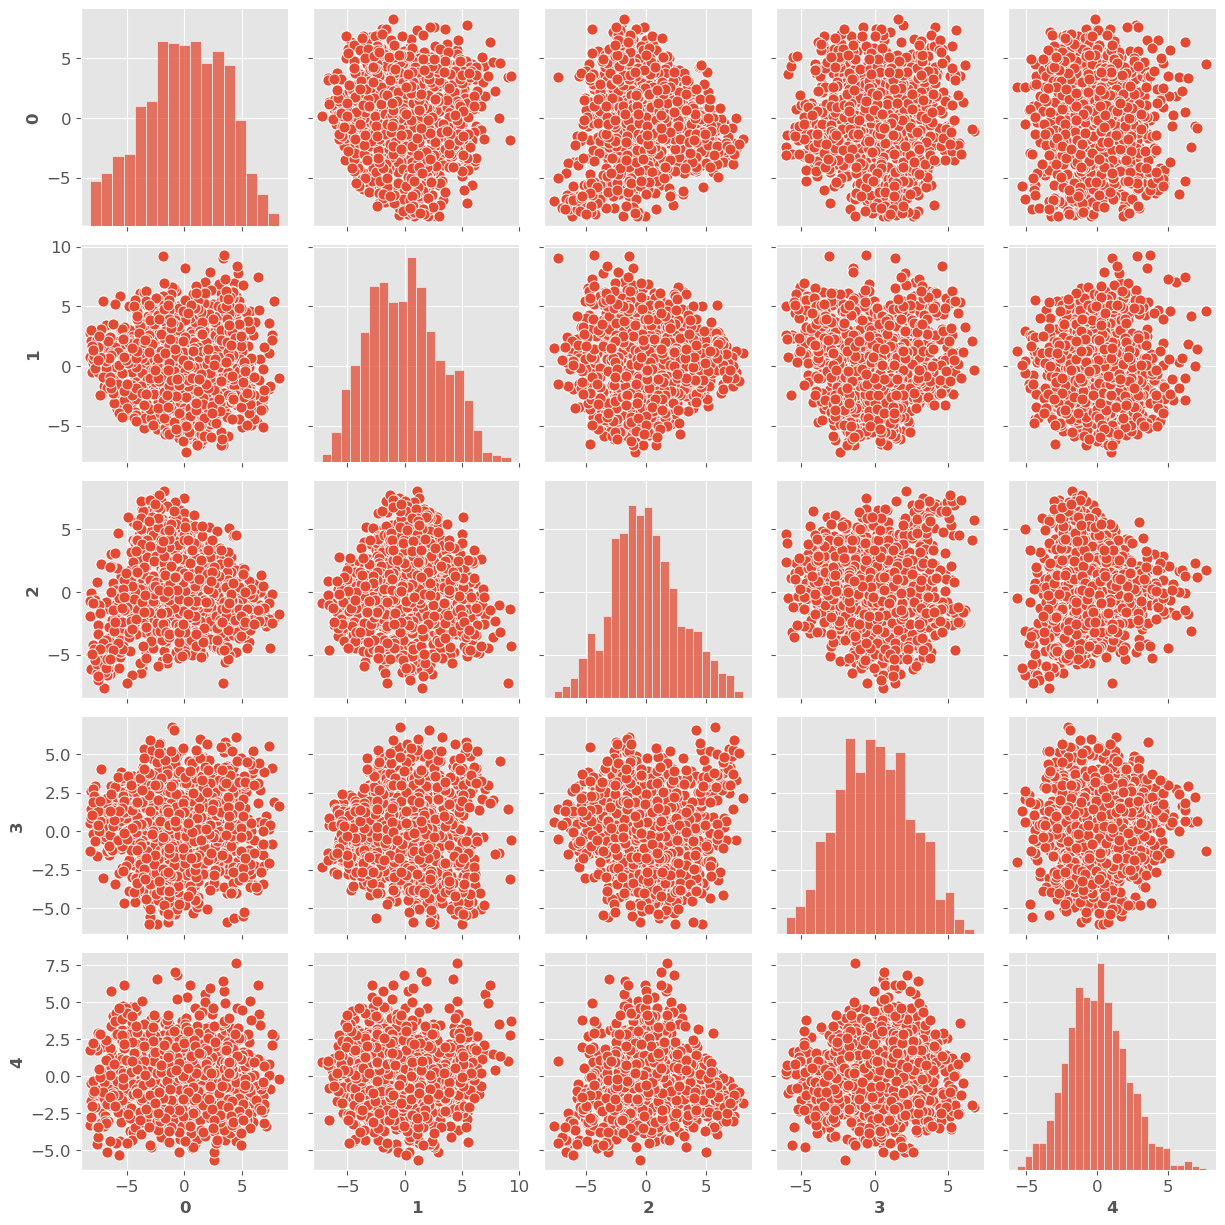

In [222]:
sns.pairplot(pca_data)

In [198]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))
def give_recommendations(index,data,print_recommendation = True):
    index_recomm =cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
    movies_recomm =  data['name'].loc[index_recomm].values
    result = {'artist':movies_recomm,'Index':index_recomm}
    if print_recommendation==True:
        print('\nThe Artists is: %s \n'%(data['name'].loc[index]))
        for k, movie in enumerate(movies_recomm):
            print('The number %i recommended artist is: %s'%(k+1,movie))
    return result


The Artists is: Bezmârâ 

The number 1 recommended artist is: Muhammed Celalettin Yüksel
The number 2 recommended artist is: Buhurizade Mustafa Itri Efendi
The number 3 recommended artist is: Ahmad Saud
The number 4 recommended artist is: Sultan Selim III
The number 5 recommended artist is: Ercan Irmak

The Artists is: Britney, Christina, Madonna 

The number 1 recommended artist is: Willow Smith
The number 2 recommended artist is: Nicole Scherzinger
The number 3 recommended artist is: Fergie
The number 4 recommended artist is: Christina Milian
The number 5 recommended artist is: Cassie

The Artists is: M. Bulteau 

The number 1 recommended artist is: Holiday Parade
The number 2 recommended artist is: Tiffany Villarreal
The number 3 recommended artist is: Cipes And The People
The number 4 recommended artist is: Stephen Gunzenhauser
The number 5 recommended artist is: Daniel Ghattas

The Artists is: KOSMOPOP2 

The number 1 recommended artist is: ILWT
The number 2 recommended artist is

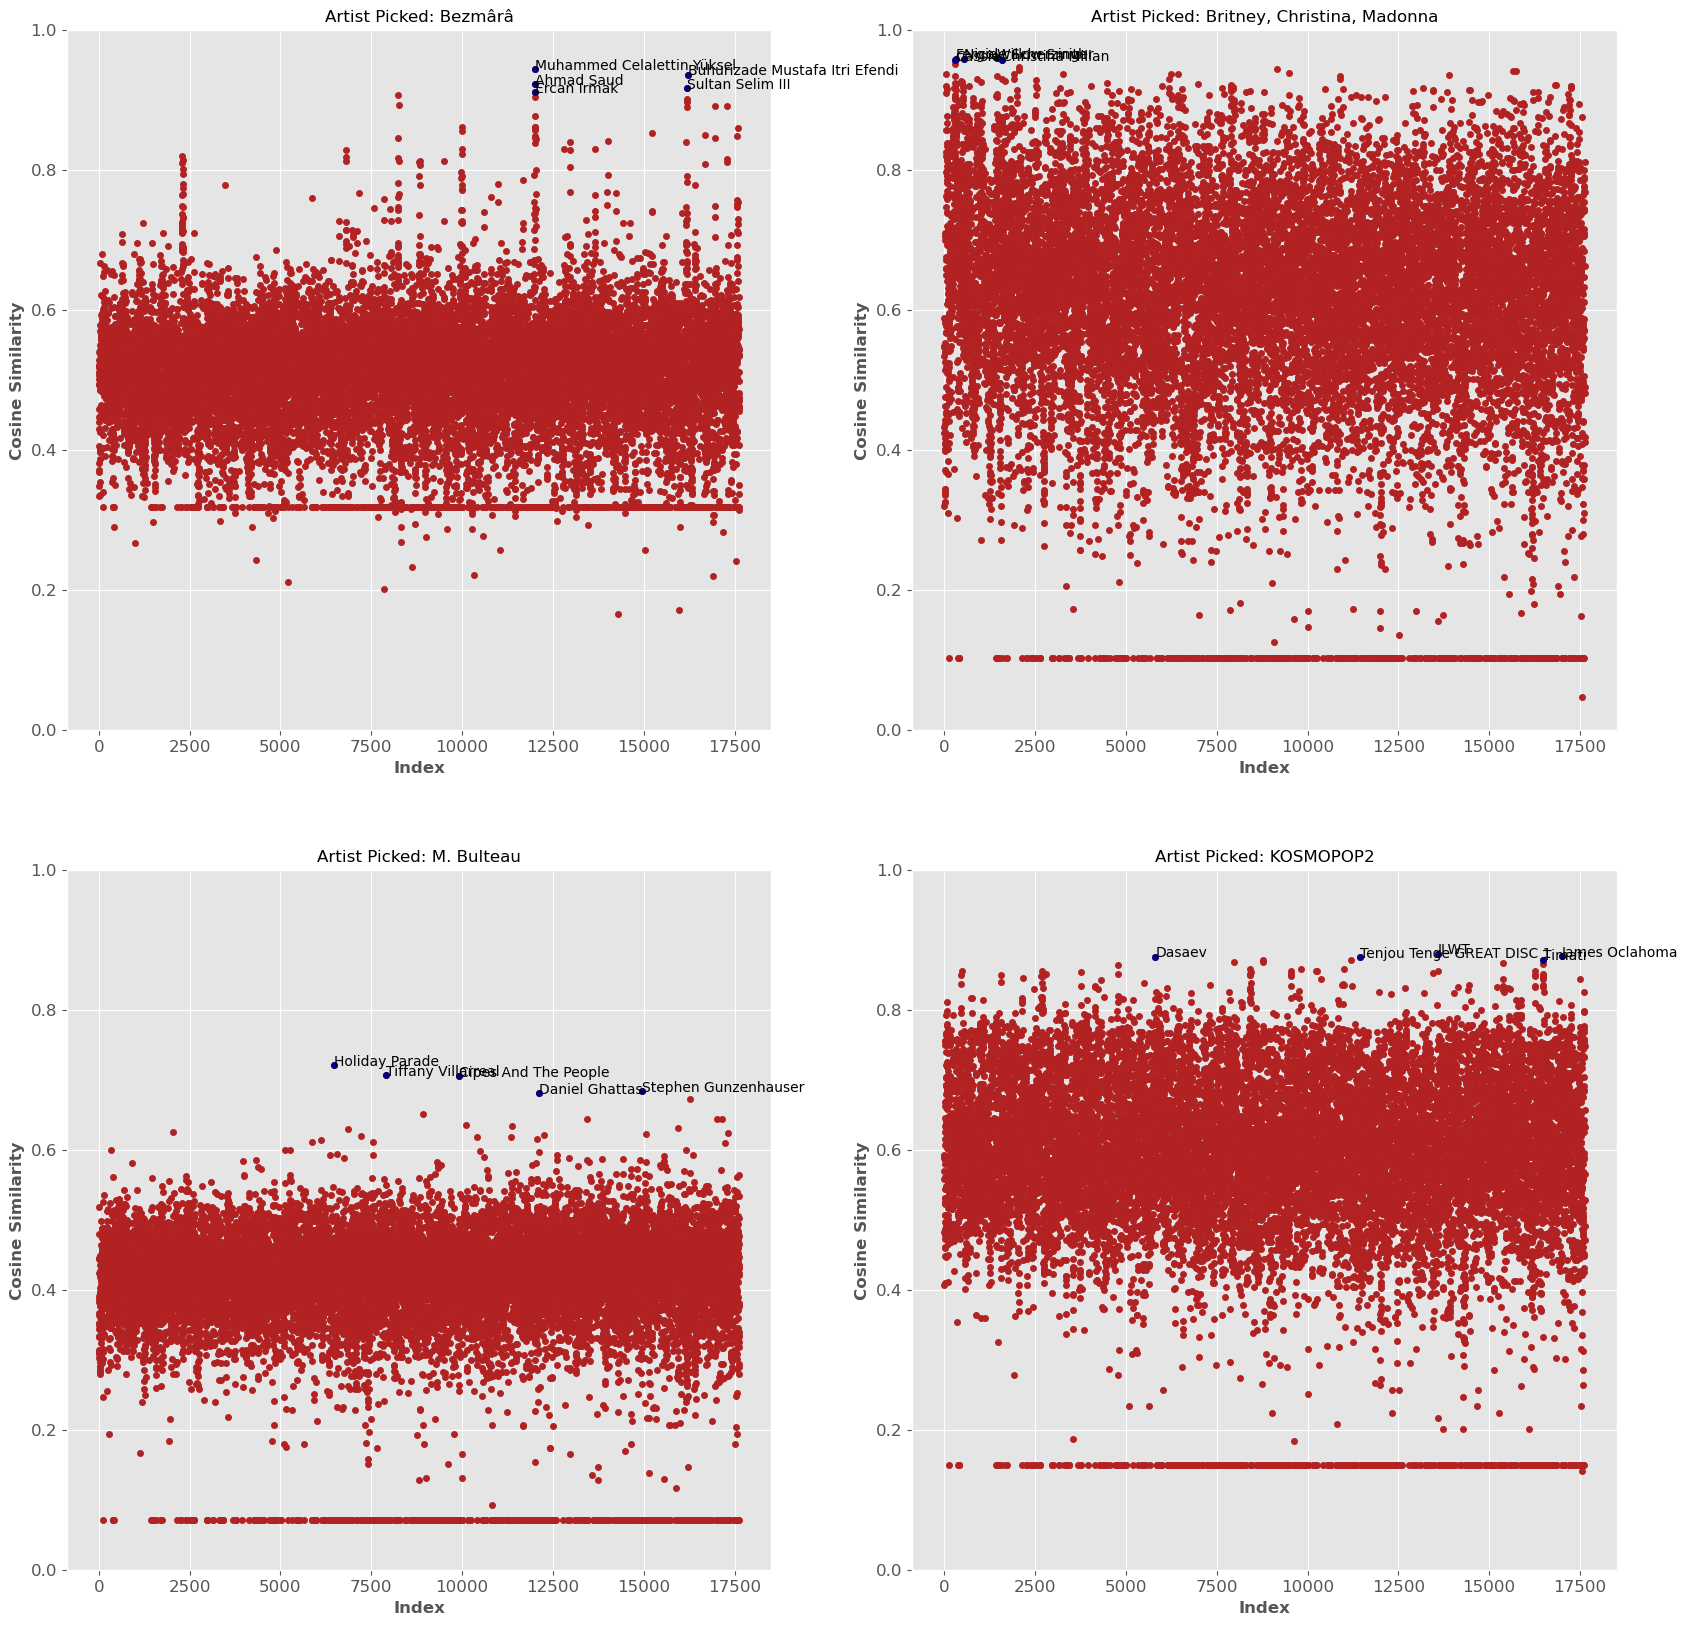

In [199]:
plt.figure(figsize=(20,20))
for q in range(1,5):
    plt.subplot(2,2,q)
    index = np.random.choice(np.arange(0,len(X)))
    to_plot_data = cos_sim_data.drop(index,axis=1)
    plt.plot(to_plot_data.loc[index],'.',color='firebrick')
    recomm_index = give_recommendations(index, artist)
    x = recomm_index['Index']
    y = cos_sim_data.loc[index][x].tolist()
    m = recomm_index['artist']
    plt.plot(x,y,'.',color='navy',label='Recommended Artist')
    plt.title('Artist Picked: '+artist['name'].loc[index])
    plt.xlabel('Index')
    k=0
    for x_i in x:
        plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
        k=k+1

    plt.ylabel('Cosine Similarity')
    plt.ylim(0,1)